In [113]:
import os
import torch
import time
import random
from utils import *
from model import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
from matplotlib.ticker import FuncFormatter
%matplotlib inline

In [114]:
fix_seed = 2023
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)

Load DDS data

In [115]:
#df1 = pd.read_csv('./data/newDF_TimeToFailure_from_3800_to_4100_WITHOUT_subwindows.csv') #p4581
df1 = pd.read_csv('./data/newDF_TimeToFailure_from_6600_to_6900_WITHOUT_subwindows.csv') #p5198

In [116]:
df1

,Unnamed: 0,LPDisp,NormStress,ShearStress,Time,Var_Ch1,Var_Ch2,TimeToStartFailure,TimeToEndFailure
0,0,30687.733861,0.000012,5.714236,6598.934301,33.115246,59.167182,0.0,0.0
1,1,30688.813777,0.000012,5.703253,6599.034301,30.498154,54.023189,5.3,0.2
2,2,30689.841227,0.000012,5.695175,6599.134301,24.764192,42.132384,5.2,0.1
3,3,30690.793302,0.000009,5.692414,6599.234301,16.365748,25.389811,5.1,0.0
4,4,30691.703534,0.000008,5.693362,6599.334301,13.040798,18.970351,5.0,6.6
...,...,...,...,...,...,...,...,...,...
3004,3004,33679.366852,0.000006,5.808759,6899.324466,9.480750,12.555576,0.4,0.4
3005,3005,33680.341518,0.000005,5.812023,6899.424466,9.565471,12.708317,0.3,0.3
3006,3006,33681.323472,0.000005,5.815231,6899.524466,9.623739,12.901281,0.2,0.2
3007,3007,33682.301801,0.000006,5.818381,6899.624466,9.703154,13.074844,0.1,0.1


In [119]:
sd_data = np.sqrt(df1.Var_Ch1.values)
stress_data = df1.ShearStress.values
ttsf_data = df1.TimeToStartFailure.values
ttef_data = df1.TimeToEndFailure.values
x = np.linspace(0, len(stress_data), len(stress_data))

Visualize DDS data

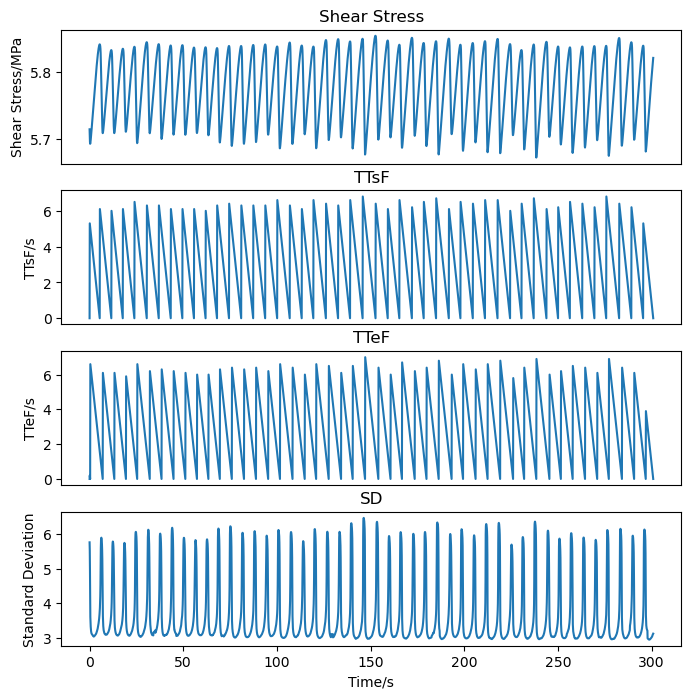

In [120]:
fig, axs = plt.subplots(4, 1, figsize=(8, 8))
fig.subplots_adjust(hspace=0.2)


# First plot
axs[0].plot(x, stress_data)
axs[0].set_ylabel('Shear Stress/MPa')
axs[0].set_title("Shear Stress")
axs[0].set_xticklabels([])
axs[0].set_xticks([])

# Second plot
axs[1].plot(x, ttsf_data)
axs[1].set_ylabel('TTsF/s')
axs[1].set_title("TTsF")
axs[1].set_xticklabels([])
axs[1].set_xticks([])

# Third plot
axs[2].plot(x, ttef_data)
axs[2].set_ylabel('TTeF/s')
axs[2].set_title("TTeF")
axs[2].set_xticklabels([])
axs[2].set_xticks([])

# Fourth plot
axs[3].plot(x, sd_data)
axs[3].set_xlabel('Time/s')
axs[3].xaxis.set_major_formatter(FuncFormatter(reduce_by_factor_10))
axs[3].set_ylabel('Standard Deviation')
axs[3].set_title("SD")

plt.show()

Scale the data with training set and choose the target among stress, ttsf, and ttef

In [121]:
train_split_idx = 1388
x_train_raw = sd_data[:train_split_idx]
#y_train_raw = stress_data[:train_split_idx] #stress
y_train_raw = ttsf_data[:train_split_idx] #ttsf
#y_train_raw = ttef_data[:train_split_idx] #ttef

In [122]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
scaler_x.fit(x_train_raw.reshape(-1, 1))
scaler_y.fit(y_train_raw.reshape(-1, 1))
x_data = scaler_x.transform(sd_data.reshape(-1, 1))

#y_data = scaler_y.transform(stress_data.reshape(-1, 1)) #stress
y_data = scaler_y.transform(ttsf_data.reshape(-1, 1)) #ttsf
#y_data = scaler_y.transform(ttef_data.reshape(-1, 1)) #ttef

Create dataset with continuous input

In [123]:
data_x, data_y = create_dataset(x_data, y_data, window_size=69)

In [124]:
data_x.shape

(2940, 70, 1)

Split the dataset by event, we only use a half for training

In [125]:
x_train = data_x[:1388]
x_val = data_x[1387:1682]
x_test = data_x[1681:2861]
y_train = data_y[:1388]
y_val = data_y[1387:1682]
y_test = data_y[1681:2861]

In [147]:
len(x_train), len(x_val), len(x_test)

(1388, 295, 1180)

Visualize training, validation, and test set

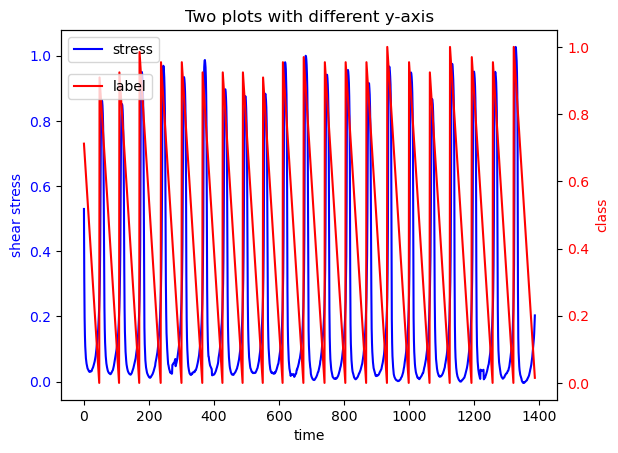

In [126]:
fig, ax1 = plt.subplots()
N = len(x_train)
x = np.linspace(0, N, N)
ax1.plot(x, x_train[:,-1,0], label='stress', color='blue')
ax1.set_xlabel('time')
ax1.set_ylabel('shear stress', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()
ax2.plot(x, y_train, label='label', color='red')
ax2.set_ylabel('class', color='red')
ax2.tick_params(axis='y', labelcolor='red')
plt.title('Two plots with different y-axis')
ax1.legend(loc='upper left')
ax2.legend(loc='upper left', bbox_to_anchor=(0, 0.9))
plt.show()

Prepare for finetuning

In [127]:
train_dataset = MultiChannelDataset(x_train, y_train)
val_dataset = MultiChannelDataset(x_val, y_val)
test_dataset = MultiChannelDataset(x_test, y_test)
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, drop_last=True)

In [128]:
len(train_dataset), len(val_dataset), len(test_dataset)

(1388, 295, 1180)

Load pretrained Model from Biaxial Experiment

In [129]:
hidden_size = 512 
kernel_size = 8
seq_len = 512
num_decoders=9

model_pretrained = Model(seq_len=seq_len, 
                         hidden_size=hidden_size, 
                         kernel_size=kernel_size,
                         num_decoders = num_decoders)

model_pretrained.load_state_dict(torch.load('./model/pretrained_biaxial.pth'))

<All keys matched successfully>

Create a smaller model for finetuning

In [130]:
seq_len_new = 70
num_decoders_new = 5
model = Model(seq_len=seq_len_new, 
              hidden_size=hidden_size, 
              kernel_size=kernel_size, 
              num_decoders = num_decoders_new)

Transfer the weights of decoder

In [131]:
model_new_decoder = list(model.decode.network.children())
model_pretrained_decoder = list(model_pretrained.decode.network.children())
for i in range(5):
    model_new_decoder[i].load_state_dict(model_pretrained_decoder[i].state_dict())

Then fix the decoder weights

In [132]:
for name, param in model.decode.named_parameters():
    param.requires_grad = False

Inspect the tunable and fronze parameters in the model

In [149]:
total_params = 0
trainable_params = 0
frozen_params = 0

for name, param in model.named_parameters():
    total_params += param.numel()
    if param.requires_grad:
        trainable_params += param.numel()
    else:
        frozen_params += param.numel()

print(f"Total parameters: {total_params}")
print(f"Tunable parameters: {trainable_params}")
print(f"Frozen parameters: {frozen_params}")

Total parameters: 19537357
Tunable parameters: 647629
Frozen parameters: 18889728


In [150]:
647629/19537357 #Tunable parameters only takes for 3.3%

0.03314824006133481

Prepare for finetuning. Learning rate (lr) and weight_decay can be adjusted.

In [137]:
train_epochs = 100
train_steps = len(train_loader)

patience = 12
lr = 1e-4 #6e-5 #4e-5
weight_decay = 4e-4 #1e-4 #3e-4

early_stopping = EarlyStopping(patience=patience, verbose=True)        
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

model.to('cuda:0')
path = './checkpoints'

Finetuning with early stopping

In [138]:
train_losses = []
val_losses = []
time_now = time.time()

for epoch in range(train_epochs):
    iter_count = 0
    total_loss = []
    model.train()
    epoch_time = time.time()
    for i, (batch_x, batch_y) in enumerate(train_loader):
        iter_count += 1
        optimizer.zero_grad()
        batch_x = batch_x.float().to('cuda:0')
        batch_y = batch_y.float().to('cuda:0')
        output = model(batch_x)
        loss = criterion(output, batch_y)
        total_loss.append(loss.item())
        if (i+1) % 100==0:
            print("\titers: {0}, epoch: {1} | loss: {2:.7f}".format(i + 1, epoch + 1, loss.item()))
            speed = (time.time()-time_now)/iter_count
            left_time = speed*((train_epochs - epoch)*train_steps - i)
            print('\tspeed: {:.4f}s/iter; left time: {:.4f}s'.format(speed, left_time))
            iter_count = 0
            time_now = time.time()
        loss.backward()
        optimizer.step()
    print("Epoch: {} cost time: {}".format(epoch+1, time.time()-epoch_time))
    train_loss = np.average(total_loss)
    train_losses.append(train_loss)
    model.eval()
    total_loss_2 = []
    with torch.no_grad():
        for i, (val_x, val_y) in enumerate(val_loader):
            val_x = val_x.float().to('cuda:0')
            val_y = val_y.float().to('cuda:0')
            output2 = model(val_x)
            loss2 = criterion(output2.detach().cpu(), val_y.detach().cpu())
            total_loss_2.append(loss2)
    vali_loss = np.average(total_loss_2)
    val_losses.append(vali_loss)
    scheduler.step()
    model.train()
    print("Epoch: {0}, Steps: {1} | Train Loss: {2:.7f} Vali Loss: {3:.7f}".format(
            epoch + 1, train_steps, train_loss, vali_loss))
    early_stopping(vali_loss, model, path)
    if early_stopping.early_stop:
        print("Early stopping")
        break

Epoch: 1 cost time: 0.18319296836853027
Epoch: 1, Steps: 21 | Train Loss: 0.0194638 Vali Loss: 0.1783116
Validation loss decreased (inf --> 0.178312).  Saving model ...
Epoch: 2 cost time: 0.16015028953552246
Epoch: 2, Steps: 21 | Train Loss: 0.0196445 Vali Loss: 0.1617177
Validation loss decreased (0.178312 --> 0.161718).  Saving model ...
Epoch: 3 cost time: 0.15919828414916992
Epoch: 3, Steps: 21 | Train Loss: 0.0179748 Vali Loss: 0.1430899
Validation loss decreased (0.161718 --> 0.143090).  Saving model ...
Epoch: 4 cost time: 0.1635138988494873
Epoch: 4, Steps: 21 | Train Loss: 0.0169908 Vali Loss: 0.1286614
Validation loss decreased (0.143090 --> 0.128661).  Saving model ...
Epoch: 5 cost time: 0.16422748565673828
Epoch: 5, Steps: 21 | Train Loss: 0.0170206 Vali Loss: 0.1152620
Validation loss decreased (0.128661 --> 0.115262).  Saving model ...
Epoch: 6 cost time: 0.1729569435119629
Epoch: 6, Steps: 21 | Train Loss: 0.0166917 Vali Loss: 0.1007763
Validation loss decreased (0.115

Visualize the training and validation loss curves

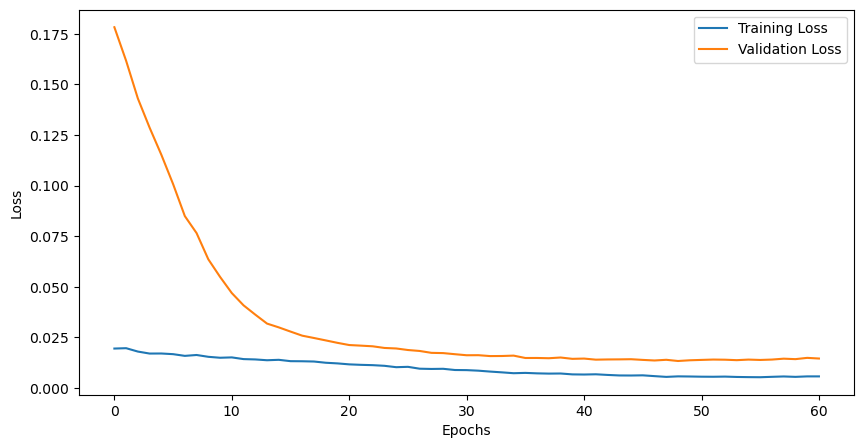

In [139]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Load the best model for evaluation

In [141]:
best_model = Model(seq_len=seq_len_new, 
                   hidden_size=hidden_size, 
                   kernel_size=kernel_size, 
                   num_decoders=num_decoders_new)

best_model.load_state_dict(torch.load('./checkpoints/checkpoint.pth'))

best_model = best_model.to('cuda:0')

Evaluate on test set

In [142]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, drop_last=True)
best_model.eval()

predictions_test = []
true_values_test = []
total_loss_mae = []
total_loss_mse = []

with torch.no_grad():
    for test_x, test_y in test_loader:
        test_x = test_x.float().to('cuda:0')
        test_y = test_y.float().to('cuda:0')
        output = best_model(test_x)
        output = output.detach().cpu().numpy()
        test_y = test_y.detach().cpu().numpy()
        loss_mae, loss_mse = metric_regression(output, test_y)
        total_loss_mae.append(loss_mae)
        total_loss_mse.append(loss_mse)
        predictions_test.extend(output)
        true_values_test.extend(test_y)
        
mae = np.average(total_loss_mae)
mse = np.average(total_loss_mse)

In [143]:
mae, mse

(0.05149344, 0.009749105)

Visualize the performance on the test set (scaled)

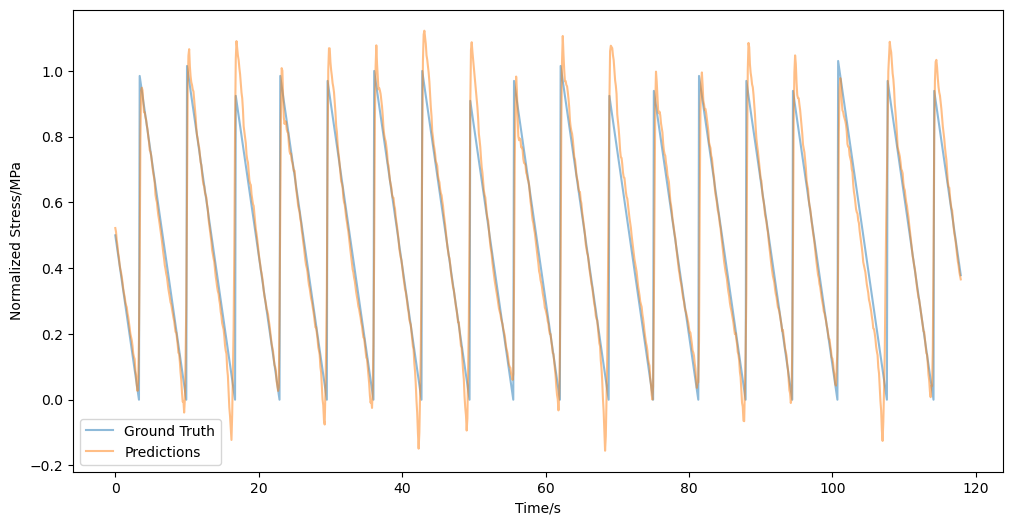

In [144]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(true_values_test, label='Ground Truth', alpha=0.5)
ax.plot(predictions_test, label='Predictions', alpha=0.5)
ax.set_xlabel('Time/s')
ax.set_ylabel('Normalized Stress/MPa')
ax.legend()
ax.xaxis.set_major_formatter(FuncFormatter(reduce_by_factor_10))
plt.show()

Visualize the performance on the test set (unscaled)

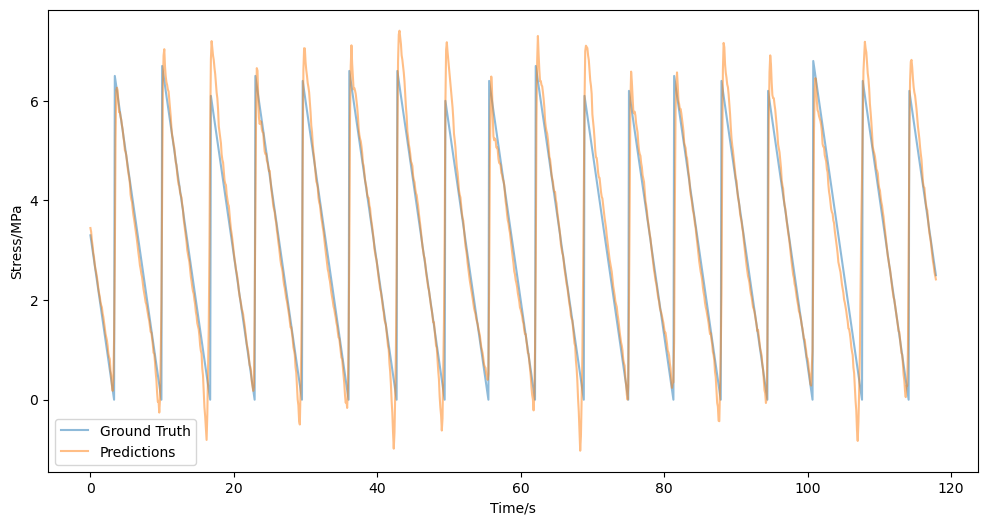

In [145]:
min_value = scaler_y.data_min_[0]
max_value = scaler_y.data_max_[0]
true_r = (np.asarray(true_values_test) * (max_value - min_value)) + min_value 
pred_r = (np.asarray(predictions_test) * (max_value - min_value)) + min_value 
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(true_r, label='Ground Truth', alpha=0.5)
ax.plot(pred_r, label='Predictions', alpha=0.5)
ax.set_xlabel('Time/s')
ax.set_ylabel('Stress/MPa')
ax.legend(loc='lower left')
ax.xaxis.set_major_formatter(FuncFormatter(reduce_by_factor_10))
plt.show()